In [1]:
import numpy as np
import random
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from pylab import mpl
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, ScalarFormatter
from matplotlib.colors import LinearSegmentedColormap
import dill

from utils.generate_and_plot_signals import generate_signals, plot_source_signals, plot_signals
from utils import eeg_microstates3
from utils.calc_fun import calc_diff

In [2]:
plt.rcParams['font.family']=['Arial','serif', 'Times New Roman']
plt.style.use('default')
mpl.rcParams["axes.unicode_minus"] = False
%config InlineBackend.figure_format = 'svg'

font = {'family':['Arial', 'Times New Roman'], 'color':'k', 'weight':'normal', 'size':10 }
colors = sns.color_palette('tab10')

# Auxiliary function

In [3]:
def draw_ms_graph(state, figsize=(4, 2), colorbar_fraction=0.025, 
                     tmin=0.0, tmax=1.0, colorbar_ticks=[]):

    matplotlib.rcParams['font.family']=['Arial', 'Times New Roman']
    plt.style.use('default')
    mpl.rcParams["axes.unicode_minus"] = False
    font = {'family' : ['Arial', 'Times New Roman'], 
        'color'  : 'k',
        'weight' : 'normal',
        'size'   : 10,
        }
    
    n_clusters = int(np.nanmax(state))
    
    tp = state.shape[0]
    if len(colorbar_ticks) == 0:
        tick_num = n_clusters
        if n_clusters > 6:
            tick_num = 5
        colorbar_ticks=np.linspace(1, n_clusters, tick_num, endpoint=True).astype(int)
    
    seg = np.full( (n_clusters, tp), np.nan )
    for i, j in enumerate(state):
        seg[:int(j), i] = j

    plt.figure(figsize=figsize)
    pixel = int(100/n_clusters)

    colors = sns.color_palette('Set3') # Set3 pastel2 tab20 
    tab = sns.color_palette('tab20')
    colors.remove(colors[1])
    colors.extend( [tab[1], tab[3], tab[5], tab[7], tab[9], tab[11], tab[13], tab[15] ] )   
    colors = colors[:n_clusters]
    my_cmap = LinearSegmentedColormap.from_list('my_cmap', colors[:n_clusters], N=n_clusters)

    plt.imshow( seg, origin='lower', cmap=my_cmap, interpolation='none', extent=[0, tp, 0, n_clusters*pixel], 
                vmin=1, vmax=n_clusters, aspect='auto');

    ax = plt.gca()
    ax.xaxis.set_minor_locator(MultipleLocator(20))

    clb = plt.colorbar(fraction=colorbar_fraction, pad=0.02, ticks=colorbar_ticks); 
    clb.set_ticks(ticks=colorbar_ticks)
    cbar_label = clb.ax.get_xticklabels() + clb.ax.get_yticklabels()
    [lab.set_font('Arial') for lab in cbar_label]  #Times New Roman  #set_fontstyle
    clb.ax.tick_params(labelsize=10)

    clb.set_label(label="State", loc="center" , fontdict=font, labelpad=1) 

    x = np.linspace(0, int(tp), num=11, endpoint=True)
    # xticks = np.around( np.linspace(tmin, tmax, num=11, endpoint=True), decimals=1)
    xticks = ['0', '', '0.2', '', '0.4', '', '0.6', '', '0.8', '', '1.0', ]
    plt.xticks(x, xticks, fontdict=font);
    plt.xlabel('Time (s)', fontdict=font);
        
    # y = np.arange(pixel, (n_clusters*pixel), step=pixel*2)
    # yticks = np.arange(1, n_clusters, 2)
    if n_clusters<6:
        y = np.arange(pixel, ((n_clusters+1)*pixel), step=pixel)
        yticks = np.arange(1, n_clusters+1, 1)
    else:
        y = np.arange(pixel, ((n_clusters+1)*pixel), step=pixel*2)
        yticks = np.arange(1, n_clusters+1, 2)
    plt.yticks(y, yticks, fontdict=font);
    plt.ylabel('State', fontdict=font);

    plt.grid(color='gray', linestyle=':', linewidth=0.5);
    plt.show();    

# Generate or load data

In [4]:
# generate 50 random trials

n_trials = 50
n_ch = 6
n_times = 1001

raw_data = np.empty((n_trials, n_ch, n_times))
Atrue = np.random.random([n_ch, n_ch])

for t in range(n_trials):
    Strue = generate_signals(stationary=False)
    raw_data[t] = Atrue.dot(Strue)

X = raw_data[0]

# with open('./saves/generate_data.pkl', 'wb') as f:
#     dill.dump([Strue, Atrue, raw_data], f)

In [5]:
with open('./saves/generate_data.pkl', 'rb') as f:
    [Strue, Atrue, raw_data] = dill.load(f)

# Microstate analysis

## Cluster into 3 clusters

[+] Data format for clustering [GFP peaks, channels]: 95 x 6

[+] Clustering algorithm: mod. K-MEANS.
	K-means run 1/5 converged after 11 iterations.
	K-means run 2/5 converged after 10 iterations.
	K-means run 3/5 converged after 5 iterations.
	K-means run 4/5 converged after 10 iterations.
	K-means run 5/5 converged after 6 iterations.
[+] Computation time: 0.01 sec

[+] Microstate back-fitting:
data_norm:  (1001, 6)
data_cluster_norm:  (95, 6)
maps:  (3, 6)

[+] Global explained variance GEV = 0.835
GEV_0: 0.097
GEV_1: 0.516
GEV_2: 0.221


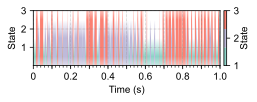

In [6]:
cluster_num = 3

avg_data = np.mean(raw_data, axis=0)

# input_data [times, chs]
maps, x, gfp_peaks, gev = eeg_microstates3.clustering(avg_data.T, fs=1000, chs=6, locs=[], mode='kmeans', 
                                                      n_clusters=cluster_num, n_win=100, interpol=False, doplot=False)
# mode = ["aahc", "kmeans", "kmedoids", "pca", "ica"]

labels = x+1

draw_ms_graph(labels, figsize=(3.5, 1.0),
              colorbar_fraction=0.015, tmin=0.0, tmax=1.0, colorbar_ticks=[]);

In [7]:
# SSE, Distance, CH_Score
calc_diff(avg_data.T, labels)

(164.04594171227578,
 12.808042071771773,
 1.4735273004691032,
 -0.06397340168377062,
 24.219314557764303)

## Cluster into 5 clusters

[+] Data format for clustering [GFP peaks, channels]: 95 x 6

[+] Clustering algorithm: mod. K-MEANS.
	K-means run 1/5 converged after 13 iterations.
	K-means run 2/5 converged after 5 iterations.
	K-means run 3/5 converged after 5 iterations.
	K-means run 4/5 converged after 11 iterations.
	K-means run 5/5 converged after 8 iterations.
[+] Computation time: 0.01 sec

[+] Microstate back-fitting:
data_norm:  (1001, 6)
data_cluster_norm:  (95, 6)
maps:  (5, 6)

[+] Global explained variance GEV = 0.888
GEV_0: 0.070
GEV_1: 0.417
GEV_2: 0.098
GEV_3: 0.217
GEV_4: 0.087


e:\论文写作\论文2数据分析\Generated data\utils\eeg_microstates3.py:718: RuntimeWarning: divide by zero encountered in scalar divide
  cv = var * (n_ch-1)**2/(n_ch-n_maps-1.)**2


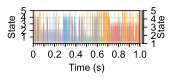

In [8]:
cluster_num = 5

# input_data [times, chs]
maps, x, gfp_peaks, gev = eeg_microstates3.clustering(avg_data.T, fs=1000, chs=6, locs=[], mode='kmeans', 
                                                      n_clusters=cluster_num, n_win=100, interpol=False, doplot=False)
# mode = ["aahc", "kmeans", "kmedoids", "pca", "ica"]

labels = x+1

draw_ms_graph(labels, figsize=(2, 0.6),
              colorbar_fraction=0.015, tmin=0.0, tmax=1.0, colorbar_ticks=[]);

In [9]:
# SSE, Distance, CH_Score
calc_diff(avg_data.T, labels)

(163.8016287072412,
 12.798501033607069,
 1.107771735317624,
 -0.09032686325856991,
 65.67043841144701)

## Cluster into 7 clusters

[+] Data format for clustering [GFP peaks, channels]: 95 x 6

[+] Clustering algorithm: mod. K-MEANS.
	K-means run 1/5 converged after 4 iterations.
	K-means run 2/5 converged after 9 iterations.
	K-means run 3/5 converged after 5 iterations.
	K-means run 4/5 converged after 10 iterations.
	K-means run 5/5 converged after 5 iterations.
[+] Computation time: 0.01 sec

[+] Microstate back-fitting:
data_norm:  (1001, 6)
data_cluster_norm:  (95, 6)
maps:  (7, 6)

[+] Global explained variance GEV = 0.910
GEV_0: 0.085
GEV_1: 0.059
GEV_2: 0.099
GEV_3: 0.059
GEV_4: 0.370
GEV_5: 0.159
GEV_6: 0.079


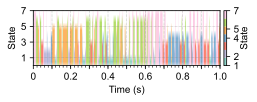

In [10]:
cluster_num = 7

# input_data [times, chs]
maps, x, gfp_peaks, gev = eeg_microstates3.clustering(avg_data.T, fs=1000, chs=6, locs=[], mode='kmeans', 
                                                      n_clusters=cluster_num, n_win=100, interpol=False, doplot=False)
# mode = ["aahc", "kmeans", "kmedoids", "pca", "ica"]

labels = x+1

draw_ms_graph(labels, figsize=(3.5, 1.0),
              colorbar_fraction=0.015, tmin=0.0, tmax=1.0, colorbar_ticks=[]);

In [12]:
# SSE, Distance, CH_Score, SI_Score, DB_Score
res = calc_diff(avg_data.T, labels)
print(res)

(163.51657538801123, 12.787359985079453, 1.0271178792909397, -0.09610362795975651, 28.18026185186948)
